## Loading Dataset and Libraries ##

In [1]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import string
import os

import spacy 
from spacy.lang.en.stop_words import STOP_WORDS
import seaborn as sns
import matplotlib.pyplot as plt
import operator
import folium
from itertools import cycle, islice
from pandas import options
import warnings
import pickle
import nltk
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from matplotlib.pyplot import figure
from nltk.corpus import stopwords 
import nltk


nltk.download('wordnet')
nltk.download('stopwords')
from tqdm import tqdm,tqdm_notebook

from  wordcloud import WordCloud
%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Raunak\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Raunak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# DATA_SET = './datasets/aclimdb.csv'
DATA_SET = './FinalDataset.csv'
df =pd.read_csv(DATA_SET, index_col = 0)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
990230,@LSDtweets put me down as a reference on that,1
138566,"shame about lucy gordon, killing herself, she ...",0
863540,"mmm I took an angelfood cake. cut it, put quin...",1
969307,has just arived in zagreb,1


## Preprocessing Data ##

In [3]:
df['sentiment'].value_counts()

0    73698
1    72062
Name: sentiment, dtype: int64

In [4]:
df.describe()

,sentiment
count,145760.000000
mean,0.494388
std,0.499970
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [5]:
df.nunique()

review       142519
sentiment         2
dtype: int64

In [6]:
#lowercasing all the words in the review
df['review']=df['review'].apply(lambda x: x.lower())
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. <br /><br />the...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,"petter mattei's ""love in the time of money"" is...",1


In [7]:
#contraction to expansion : 
#converting the words in their contracted form to their extracted form eg. he'll to he will
#using the cont_to_exp() and a dictionary:{key: contractions,value:expansion}
contractions = { 
"ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not","couldn't've": "could not have",
"didn't": "did not","doesn't": "does not","don't": "do not",
"hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not",
"he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he will have","he's": "he is","how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how does",
"i'd": "i would","i'd've": "i would have","i'll": "i will","i'll've": "i will have","i'm": "i am","i've": "i have","isn't": "is not",
"it'd": "it would","it'd've": "it would have","it'll": "it will","it'll've": "it will have","it's": "it is","let's": "let us",
"ma'am": "madam","mayn't": "may not",
"might've": "might have","mightn't": "might not","mightn't've": "might not have",
"must've": "must have","mustn't": "must not","mustn't've": "must not have",
"needn't": "need not","needn't've": "need not have",
"o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have",
"shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have",
"she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is",
"should've": "should have","shouldn't": "should not","shouldn't've": "should not have",
"so've": "so have","so's": "so is",
"that'd": "that would","that'd've": "that would have","that's": "that is",
"there'd": "there would","there'd've": "there would have","there's": "there is",
"they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have",
"to've": "to have","wasn't": "was not",
" u ": " you "," ur ": " your "," n ": " and ",
"ain't": "is not", "aren't": "are not","can't": "cannot", "cause": "because", "could've": "could have", "couldn't": "could not",
"didn't": "did not",  "doesn't": "does not", "don't": "do not", 
"hadn't": "had not", "hasn't": "has not", "haven't": "have not",
"he'd": "he would","he'll": "he will", "he's": "he is", 
"how'd": "how did", "how'd'y": "how do you", 
"how'll": "how will", "how's": "how is",
"I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
"i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
"it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
"mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
"mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
"oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
"she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
"should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
"this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
"there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
"they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
"wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
"we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
"what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
"where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
"why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
"would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
"y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
"you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
"you're": "you are", "you've": "you have"}
def cont_to_exp(x):
    if type(x) is str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key,value)
        return x
    else : 
        return x
df['review'] = df['review'].apply(lambda x:cont_to_exp(x))


In [8]:
# Removing the urls from the reviews
df['review']=df['review'].apply(lambda x: re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?','',x)) 

In [9]:
#Stopword removal : Stopwords are the words that appear quite frequently in a sentence and do not have a significant contribution to the meaning of the sentence. Therefore they can be removed.
df['review'] = df['review'].apply(lambda x:" ".join([t for t in x.split() if t not in STOP_WORDS ]))


In [10]:
# Removal of special characters from the reviews
df['review']=df['review'].apply(lambda x:re.sub(r'[^0-9a-zA-Z *]','',x))
df['review']=df['review'].apply(lambda x:re.sub(r'[^a-zA-z0-9\s]','',x))

df['review'] = df['review'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))


In [11]:
#Removal of mulitple spaces between the words in the review
df["review"]=df["review"].apply(lambda x: " ".join(x.split()))


In [12]:
#Removal of HTML Tags: from the reviews
df['review'] = df['review'].apply(lambda x:BeautifulSoup(x,'lxml').get_text())

#Remove tags and links 
tag = re.compile(r'<[^>]+>')

df['review'] = df['review'].apply(lambda x: tag.sub('', x)) #removing html labels

df['review'] = df['review'].replace(r'http\S+', '', regex=True).replace(r'www.\S+', '', regex=True).replace(r'http\S+', '', regex=True).replace(r'"', '', regex=True)

df

,review,sentiment
0,reviewers mentioned watching 1 oz episode hook...,1
1,wonderful little production br br the filming ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks zombie...,0
4,petter matteis love time money visually stunni...,1
...,...,...
990230,lsdtweets reference,1
138566,shame lucy gordon killing herself spiderman 3 ...,0
863540,mmm took angelfood cake cut it quince amp rose...,1
969307,arived zagreb,1


In [13]:
# Removal of Numbers
df['review']=df['review'].apply(lambda x:re.sub(r'[0-9]+','',x))

In [14]:
# Removal of usernames from the reviews
df['review']=df['review'].apply(lambda x:re.sub(r'@[A-Za-z0–9]+','',x))
df.sample(10)

,review,sentiment
1322342,smileybernice hey berns miss too,1
310147,ruch visited families fall surprised lot broke...,0
408349,hate hayfever today worst day,0
1500197,rat race swimming chicafor,1
39559,me oh created fantastic deck synergy well hear...,0
447902,catching tv sad that john drunk silly night hi...,0
42846,east palace west palace reminded somewhat dete...,0
761100,taxes affilates programs california dollars m...,0
68481,mr paul christoph sandrock best pubg teammate ...,1
393647,feeling hot ltdaystiltheendgt,0


In [15]:
# Tokenization and Lemmanization

nltk.download('omw-1.4')

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w, pos="v") for w in w_tokenizer.tokenize(text)])

df['review'] = df.review.apply(lemmatize_text).copy()

df

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Raunak\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,review,sentiment
0,reviewers mention watch oz episode hook right ...,1
1,wonderful little production br br the film tec...,1
2,think wonderful way spend time hot summer week...,1
3,basically family little boy jake think zombie ...,0
4,petter matteis love time money visually stun f...,1
...,...,...
990230,lsdtweets reference,1
138566,shame lucy gordon kill herself spiderman movie...,0
863540,mmm take angelfood cake cut it quince amp rise...,1
969307,arived zagreb,1


In [16]:
#word cloud visualization 
df_positive = df[df['sentiment'] == 1]
bag_of_words_positive =' '.join(df_positive['review'])
bag_of_words_positive = bag_of_words_positive.split()

df_negative = df[df['sentiment'] == 0]
bag_of_words_negative =' '.join(df_negative['review'])
bag_of_words_negative = bag_of_words_negative.split()

In [17]:
x = ' '.join(bag_of_words_positive[:20000])
len(bag_of_words_positive)
print(x)

y = ' '.join(bag_of_words_negative[:20000])
len(bag_of_words_negative)
print(y)

reviewers mention watch oz episode hook right exactly happen mebr br the thing strike oz brutality unflinching scenes violence set right word go trust me faint hearted timid pull punch regard drug sex violence hardcore classic use wordbr br it call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cells glass front face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffle death star dodgy deal shady agreements far awaybr br i main appeal fact go show dare forget pretty picture paint mainstream audiences forget charm forget romanceoz mess around episode saw strike nasty surreal ready it watch more develop taste oz get accustom high level graphic violence violence injustice crook guard sell nickel inmates kill order away it mannered middle class inmates turn prison bitch lack street skills prison experience watch oz comfortable uncomfortable viewingthats touch d

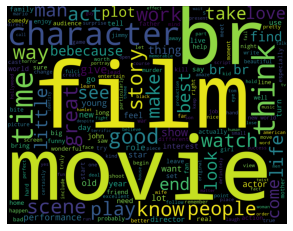

In [18]:
# for positive : 
from PIL import Image
wc = WordCloud(width=1800,height=1400).generate(x)
plt.imshow(wc)
plt.axis("off")
plt.show()

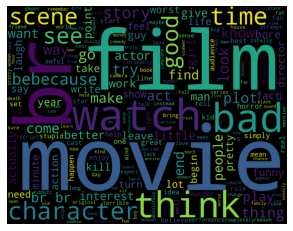

In [19]:
#for negative : 
wc = WordCloud(width=1800,height=1400).generate(y)
plt.imshow(wc)
plt.axis("off")
plt.show()

## Splitting Data ##

In [20]:
# Splitting Dataset into training and testing sets
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score

df = df.sample(50000)

x = pd.DataFrame(df, columns = ['review']) 
y = pd.DataFrame(df, columns = ['sentiment']) 

# Split dataset to train and test set.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

print("Shape of x_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_test:  ", X_test.shape)
print("Shape of y_test:  ", y_test.shape)

Shape of x_train:  (37500, 1)
Shape of y_train:  (37500, 1)
Shape of x_test:   (12500, 1)
Shape of y_test:   (12500, 1)


## Vectorization with TF-IDF ##

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

train = X_train['review'].tolist()
test = X_test['review'].tolist()
STOPWORDS = set(stopwords.words('english'))

tfidf_vectorizer = TfidfVectorizer(max_features=1000, dtype=np.float32)

tfidfX_train = tfidf_vectorizer.fit_transform(train)
tfidfX_train = tfidfX_train.toarray()

tfidfX_test = tfidf_vectorizer.transform(test)
tfidfX_test = tfidfX_test.toarray()

print("TF-IDF train shape:", tfidfX_train.shape)
print("TF-IDF test shape:", tfidfX_test.shape)

TF-IDF train shape: (37500, 1000)
TF-IDF test shape: (12500, 1000)


## Naive Bayes ##

In [22]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(tfidfX_train,y_train)

C:\Users\Raunak\miniconda3\envs\torch\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()

In [23]:
# Making Predictions
y_pred_nb = nb.predict(tfidfX_test)

# Evaluation Metrics

nb_accuracy = accuracy_score(y_test,y_pred_nb)*100
nb_matrix = confusion_matrix(y_test,y_pred_nb)
nb_precision = nb_matrix[0][0]*100/(nb_matrix[0][0]+nb_matrix[1][0])
nb_recall = nb_matrix[0][0]*100/(nb_matrix[0][0]+nb_matrix[0][1])

print("Accuracy : ",nb_accuracy)
print("Confusion_matrix:\n",nb_matrix)
print("precision:",nb_precision)
print("recall:",nb_recall)

Accuracy :  74.992
Confusion_matrix:
 [[4908 1415]
 [1711 4466]]
precision: 74.15017374225714
recall: 77.62138225525858


## SVM ##

In [24]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

svm = LinearSVC(random_state=42,max_iter=200)
svm.fit(tfidfX_train,y_train)

C:\Users\Raunak\miniconda3\envs\torch\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVC(max_iter=200, random_state=42)

In [25]:
# Making Predictions
y_pred_svm = svm.predict(tfidfX_test)

# Evaluation Metrics

svm_accuracy = accuracy_score(y_test,y_pred_svm)*100
svm_matrix = confusion_matrix(y_test,y_pred_svm)
svm_precision = svm_matrix[0][0]*100/(svm_matrix[0][0]+svm_matrix[1][0])
svm_recall = svm_matrix[0][0]*100/(svm_matrix[0][0]+svm_matrix[0][1])

print("Accuracy : ",svm_accuracy)
print("Confusion_matrix:\n",svm_matrix)
print("precision:",svm_precision)
print("recall:",svm_recall)

Accuracy :  75.8
Confusion_matrix:
 [[4643 1680]
 [1345 4832]]
precision: 77.53841015364061
recall: 73.43033370235648


## Random Forest ##

In [26]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
parameters = {
    'n_estimators': [100,150],
    'max_depth': [2,10,None],
    'criterion': ['gini', 'entropy']
}

cv = GridSearchCV(rf,parameters)
cv.fit(tfidfX_train,y_train.values.ravel())
print_results(cv)

BEST PARAMS: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 150}

0.682 (+/-0.015) for {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 100}
0.687 (+/-0.016) for {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 150}
0.714 (+/-0.014) for {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
0.721 (+/-0.005) for {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 150}
0.766 (+/-0.007) for {'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}
0.767 (+/-0.006) for {'criterion': 'gini', 'max_depth': None, 'n_estimators': 150}
0.687 (+/-0.012) for {'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 100}
0.69 (+/-0.013) for {'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 150}
0.716 (+/-0.008) for {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}
0.721 (+/-0.011) for {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 150}
0.766 (+/-0.004) for {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}
0.767 (+/-0.00

In [32]:
rf1 = RandomForestClassifier(n_estimators=150,max_depth=None)
rf1.fit(tfidfX_train,y_train)

C:\Users\Raunak\miniconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(n_estimators=150)

In [33]:
# Making Predictions
y_pred_rf1 = rf1.predict(tfidfX_test)

# Evaluation Metrics

rf1_accuracy = accuracy_score(y_test,y_pred_rf1)*100
rf1_matrix = confusion_matrix(y_test,y_pred_rf1)
rf1_precision = rf1_matrix[0][0]*100/(rf1_matrix[0][0]+rf1_matrix[1][0])
rf1_recall = rf1_matrix[0][0]*100/(rf1_matrix[0][0]+rf1_matrix[0][1])

print("Accuracy : ",rf1_accuracy)
print("Confusion_matrix:\n",rf1_matrix)
print("precision:",rf1_precision)
print("recall:",rf1_recall)

Accuracy :  76.824
Confusion_matrix:
 [[4763 1560]
 [1337 4840]]
precision: 78.08196721311475
recall: 75.32816700933101


## Logistic Regression ##

In [34]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0,solver='lbfgs')

lr.fit(tfidfX_train,y_train)

C:\Users\Raunak\miniconda3\envs\torch\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=0)

In [35]:
# Making Predictions
y_pred_lr = lr.predict(tfidfX_test)

# Evaluation Metrics

lr_accuracy = accuracy_score(y_test,y_pred_lr)*100
lr_matrix = confusion_matrix(y_test,y_pred_lr)
lr_precision = lr_matrix[0][0]*100/(lr_matrix[0][0]+lr_matrix[1][0])
lr_recall = lr_matrix[0][0]*100/(lr_matrix[0][0]+lr_matrix[0][1])

print("Accuracy : ",lr_accuracy)
print("Confusion_matrix:\n",lr_matrix)
print("precision:",lr_precision)
print("recall:",lr_recall)

Accuracy :  76.048
Confusion_matrix:
 [[4667 1656]
 [1338 4839]]
precision: 77.71856786011656
recall: 73.80990036375138


## Extra Tree Classifier ##

In [30]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(random_state=123)
etc.fit(tfidfX_train,y_train)

C:\Users\Raunak\miniconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


ExtraTreesClassifier(random_state=123)

In [31]:
# Making Predictions
y_pred_etc = etc.predict(tfidfX_test)

# Evaluation Metrics

etc_accuracy = accuracy_score(y_test,y_pred_etc)*100
etc_matrix = confusion_matrix(y_test,y_pred_etc)
etc_precision = etc_matrix[0][0]*100/(etc_matrix[0][0]+etc_matrix[1][0])
etc_recall = etc_matrix[0][0]*100/(etc_matrix[0][0]+etc_matrix[0][1])

print("Accuracy : ",etc_accuracy)
print("Confusion_matrix:\n",etc_matrix)
print("precision:",etc_precision)
print("recall:",etc_recall)

Accuracy :  77.456
Confusion_matrix:
 [[4849 1474]
 [1344 4833]]
precision: 78.29807847569838
recall: 76.68828087932943


## Voting ##

In [36]:
# Defining Estimators

estimators = [('nb',nb),('svm',svm),('rf1',rf1),('lr',lr),('etc',etc)]
estimators

[('nb', MultinomialNB()),
 ('svm', LinearSVC(max_iter=200, random_state=42)),
 ('rf1', RandomForestClassifier(n_estimators=150)),
 ('lr', LogisticRegression(random_state=0)),
 ('etc', ExtraTreesClassifier(random_state=123))]

In [37]:
# Evaluating the Estimator

from sklearn.ensemble import VotingClassifier
vc = VotingClassifier(estimators, weights=[1,1,2,1,2])
vc.fit(tfidfX_train,y_train)

C:\Users\Raunak\miniconda3\envs\torch\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Raunak\miniconda3\envs\torch\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingClassifier(estimators=[('nb', MultinomialNB()),
                             ('svm', LinearSVC(max_iter=200, random_state=42)),
                             ('rf1', RandomForestClassifier(n_estimators=150)),
                             ('lr', LogisticRegression(random_state=0)),
                             ('etc', ExtraTreesClassifier(random_state=123))],
                 weights=[1, 1, 2, 1, 2])

In [38]:
# Making Predictions
y_pred_vc = vc.predict(tfidfX_test)

# Evaluation Metrics

vc_accuracy = accuracy_score(y_test,y_pred_vc)*100
vc_matrix = confusion_matrix(y_test,y_pred_vc)
vc_precision = vc_matrix[0][0]*100/(vc_matrix[0][0]+vc_matrix[1][0])
vc_recall = vc_matrix[0][0]*100/(vc_matrix[0][0]+vc_matrix[0][1])

print("Accuracy : ",vc_accuracy)
print("Confusion_matrix:\n",vc_matrix)
print("precision:",vc_precision)
print("recall:",vc_recall)

Accuracy :  77.78399999999999
Confusion_matrix:
 [[4841 1482]
 [1295 4882]]
precision: 78.89504563233376
recall: 76.56175865886446


In [39]:
print("Testing Accuracies")
acc_list = {
    'Naive Bayes':nb_accuracy,
    'SVM':svm_accuracy,
    'Random Forest':rf1_accuracy,
    'Logistic Regression':lr_accuracy,
    'Extra Tree Classifier':etc_accuracy,
    'Voting Classifier':vc_accuracy
}

precision_list = {
    'Naive Bayes':nb_precision,
    'SVM':svm_precision,
    'Random Forest':rf1_precision,
    'Logistic Regression':lr_precision,
    'Extra Tree Classifier':etc_precision,
    'Voting Classifier':vc_precision
}

recall_list={
    'Naive Bayes':nb_recall,
    'SVM':svm_recall,
    'Random Forest':rf1_recall,
    'Logistic Regression':lr_recall,
    'Extra Tree Classifier':etc_recall,
    'Voting Classifier':vc_recall
    
}
acc_df_test = pd.DataFrame.from_dict(acc_list,orient="index",columns=['Accuracy'])
prec_df_test = pd.DataFrame.from_dict(precision_list,orient="index",columns=['Precision'])
f1_df_test = pd.DataFrame.from_dict(recall_list,orient="index",columns=['Recall'])
df_test = pd.concat([acc_df_test,prec_df_test,f1_df_test],axis = 1)
df_test

Testing Accuracies


,Accuracy,Precision,Recall
Naive Bayes,74.992,74.150174,77.621382
SVM,75.800,77.538410,73.430334
Random Forest,76.824,78.081967,75.328167
Logistic Regression,76.048,77.718568,73.809900
Extra Tree Classifier,77.456,78.298078,76.688281
Voting Classifier,77.784,78.895046,76.561759
